<a href="https://colab.research.google.com/github/Vargol/StableDiffusionColabs/blob/main/SDXL/InstantID_lcm_sdxl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
%pip install --quiet --upgrade diffusers transformers accelerate mediapy insightface einops onnxruntime
! git clone https://github.com/InstantID/InstantID.git
! gdown 18wEUfMNohBJ4K3Ly5wpTejPfDzp-8fI8

fatal: destination path 'InstantID' already exists and is not an empty directory.
Downloading...
From (original): https://drive.google.com/uc?id=18wEUfMNohBJ4K3Ly5wpTejPfDzp-8fI8
From (redirected): https://drive.google.com/uc?id=18wEUfMNohBJ4K3Ly5wpTejPfDzp-8fI8&confirm=t&uuid=3b4ff760-a9a9-4453-8536-ae433162f232
To: /content/antelopev2.zip
100% 361M/361M [00:03<00:00, 93.6MB/s]


In [7]:
%%shell
if [[ ! -d /content/models ]]
then

  mkdir  /content/models
  cd /content/models
  unzip /content/antelopev2.zip
fi

In [8]:
import mediapy as media
import random
import sys
import torch
import gc
import time
import cv2

import cv2
import torch
import numpy as np
from PIL import Image

sys.path.insert(0,'/content/InstantID')

from insightface.app import FaceAnalysis
from pipeline_stable_diffusion_xl_instantid import StableDiffusionXLInstantIDPipeline, draw_kps

from diffusers import AutoencoderKL, UniPCMultistepScheduler, LCMScheduler
from diffusers.models import ControlNetModel

from huggingface_hub import hf_hub_download


hf_hub_download(repo_id="InstantX/InstantID", filename="ControlNetModel/config.json", local_dir="./checkpoints")
hf_hub_download(repo_id="InstantX/InstantID", filename="ControlNetModel/diffusion_pytorch_model.safetensors", local_dir="./checkpoints")
hf_hub_download(repo_id="InstantX/InstantID", filename="ip-adapter.bin", local_dir="./checkpoints")


styles = {
"Enhance" : {
"Positive" : "breathtaking {prompt} . award-winning, professional, highly detailed",
"Negative" : "ugly, deformed, noisy, blurry, distorted, grainy",
},
"Anime" : {
"Positive" : "anime artwork {prompt} . anime style, key visual, vibrant, studio anime,  highly detailed",
"Negative" : "photo, deformed, black and white, realism, disfigured, low contrast",
},
"Photographic" : {
"Positive" : "cinematic photo {prompt} . 35mm photograph, film, bokeh, professional, 4k, highly detailed",
"Negative" : "drawing, painting, crayon, sketch, graphite, impressionist, noisy, blurry, soft, deformed, ugly",
},
"Digital art" : {
"Positive" : "concept art {prompt} . digital artwork, illustrative, painterly, matte painting, highly detailed",
"Negative" : "photo, photorealistic, realism, ugly",
},
"Comic book" : {
"Positive" : "comic {prompt} . graphic illustration, comic art, graphic novel art, vibrant, highly detailed",
"Negative" : "photograph, deformed, glitch, noisy, realistic, stock photo",
},
"Fantasy art" : {
"Positive" : "ethereal fantasy concept art of  {prompt} . magnificent, celestial, ethereal, painterly, epic, majestic, magical, fantasy art, cover art, dreamy",
"Negative" : "photographic, realistic, realism, 35mm film, dslr, cropped, frame, text, deformed, glitch, noise, noisy, off-center, deformed, cross-eyed, closed eyes, bad anatomy, ugly, disfigured, sloppy, duplicate, mutated, black and white",
},
"Analog film" : {
"Positive" : "analog film photo {prompt} . faded film, desaturated, 35mm photo, grainy, vignette, vintage, Kodachrome, Lomography, stained, highly detailed, found footage",
"Negative" : "painting, drawing, illustration, glitch, deformed, mutated, cross-eyed, ugly, disfigured",
},
"Neonpunk" : {
"Positive" : "neonpunk style {prompt} . cyberpunk, vaporwave, neon, vibes, vibrant, stunningly beautiful, crisp, detailed, sleek, ultramodern, magenta highlights, dark purple shadows, high contrast, cinematic, ultra detailed, intricate, professional",
"Negative" : "painting, drawing, illustration, glitch, deformed, mutated, cross-eyed, ugly, disfigured",
},
"Isometric" : {
"Positive" : "isometric style {prompt} . vibrant, beautiful, crisp, detailed, ultra detailed, intricate",
"Negative" : "deformed, mutated, ugly, disfigured, blur, blurry, noise, noisy, realistic, photographic",
},
"Lowpoly" : {
"Positive" : "low-poly style {prompt} . low-poly game art, polygon mesh, jagged, blocky, wireframe edges, centered composition",
"Negative" : "noisy, sloppy, messy, grainy, highly detailed, ultra textured, photo",
},
"Origami" : {
"Positive" : "origami style {prompt} . paper art, pleated paper, folded, origami art, pleats, cut and fold, centered composition",
"Negative" : "noisy, sloppy, messy, grainy, highly detailed, ultra textured, photo",
},
"Line art" : {
"Positive" : "line art drawing {prompt} . professional, sleek, modern, minimalist, graphic, line art, vector graphics",
"Negative" : "anime, photorealistic, 35mm film, deformed, glitch, blurry, noisy, off-center, deformed, cross-eyed, closed eyes, bad anatomy, ugly, disfigured, mutated, realism, realistic, impressionism, expressionism, oil, acrylic",
},
"Craft clay" : {
"Positive" : "play-doh style {prompt} . sculpture, clay art, centered composition, Claymation",
"Negative" : "sloppy, messy, grainy, highly detailed, ultra textured, photo",
},
"Cinematic" : {
"Positive" : "cinematic film still {prompt} . shallow depth of field, vignette, highly detailed, high budget Hollywood movie, bokeh, cinemascope, moody, epic, gorgeous, film grain, grainy",
"Negative" : "anime, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured",
},
"3d-model" : {
"Positive" : "professional 3d model {prompt} . octane render, highly detailed, volumetric, dramatic lighting",
"Negative" : "ugly, deformed, noisy, low poly, blurry, painting",
},
"Pixel art" : {
"Positive" : "pixel-art {prompt} . low-res, blocky, pixel art style, 8-bit graphics",
"Negative" : "sloppy, messy, blurry, noisy, highly detailed, ultra textured, photo, realistic",
},
"Texture" : {
"Positive" : "texture {prompt} top down close-up",
"Negative" : "ugly, deformed, noisy, blurry",
}
}

aspects = {
"12:5" :  { 'x' : 1536  , 'y' :  640 },
"7:4" :   { 'x' : 1344  , 'y' :  768 },
"19:13" : { 'x' : 1216  , 'y' :  832  },
"9:7" :   { 'x' : 1152 , 'y' : 896  },
"1:1" :   { 'x' : 1024 , 'y' : 1024 },
"7:9" :   { 'x' : 896  , 'y' : 1152  },
"13:19" : { 'x' : 832  , 'y' :  1216 },
"4:7" :   { 'x' : 768  , 'y' :  1344 },
"5:12" :  { 'x' : 640  , 'y' :  1536 }
}




In [9]:
#model_id = "ptx0/terminus-xl-gamma-v2"
#model_id = "stabilityai/stable-diffusion-xl-base-1.0"
model_id = "dataautogpt3/OpenDalleV1.1"
#model_id = "SG161222/RealVisXL_V3.0"
#model_id ="stablediffusionapi/zavychromaxl"
#model_id ="Vargol/lcm_sdxl_full_model"

# prepare 'antelopev2' under ./models
app = FaceAnalysis(name='antelopev2', root='./', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

# prepare models under ./checkpoints
face_adapter = f'./checkpoints/ip-adapter.bin'
controlnet_path = f'./checkpoints/ControlNetModel'

controlnet = ControlNetModel.from_pretrained(controlnet_path, torch_dtype=torch.float16)

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix",
                                    torch_dtype=torch.float16,
                                    force_upcast=False).to('cuda')


pipe = StableDiffusionXLInstantIDPipeline.from_pretrained(
    model_id,
    controlnet=controlnet,
    vae=vae,
    use_safetensors=True,
    variant="fp16",
    torch_dtype=torch.float16
)
pipe.to('cuda')



#pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)


pipe.enable_vae_tiling()

# load adapter
pipe.load_ip_adapter_instantid(face_adapter)

pipe.set_ip_adapter_scale(0.8)

lcm_lora_id = "latent-consistency/lcm-lora-sdxl"

pipe.load_lora_weights(lcm_lora_id, torch_dtype=torch.float16)


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/glintr100.onnx recognition ['None', 3, 112, 112] 127.5 127.5
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: ./models/antelopev2/scrfd_10g_bnkps.onnx detection [1, 3, '?', '?'] 127.5 128.0
set det-size: (640, 640)


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'interpolation_type': 'linear', 'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


The next cell is where you set you parameters and run Stable Diffusion.

The cell is re-runable, so you can edit the parameters and run without recreating the environment


  0%|          | 0/6 [00:00<?, ?it/s]

Prompt:	a Woman dressed as Sappho by Auguste Mengin
Style:	Cinematic
Seed:	2481664433816939490



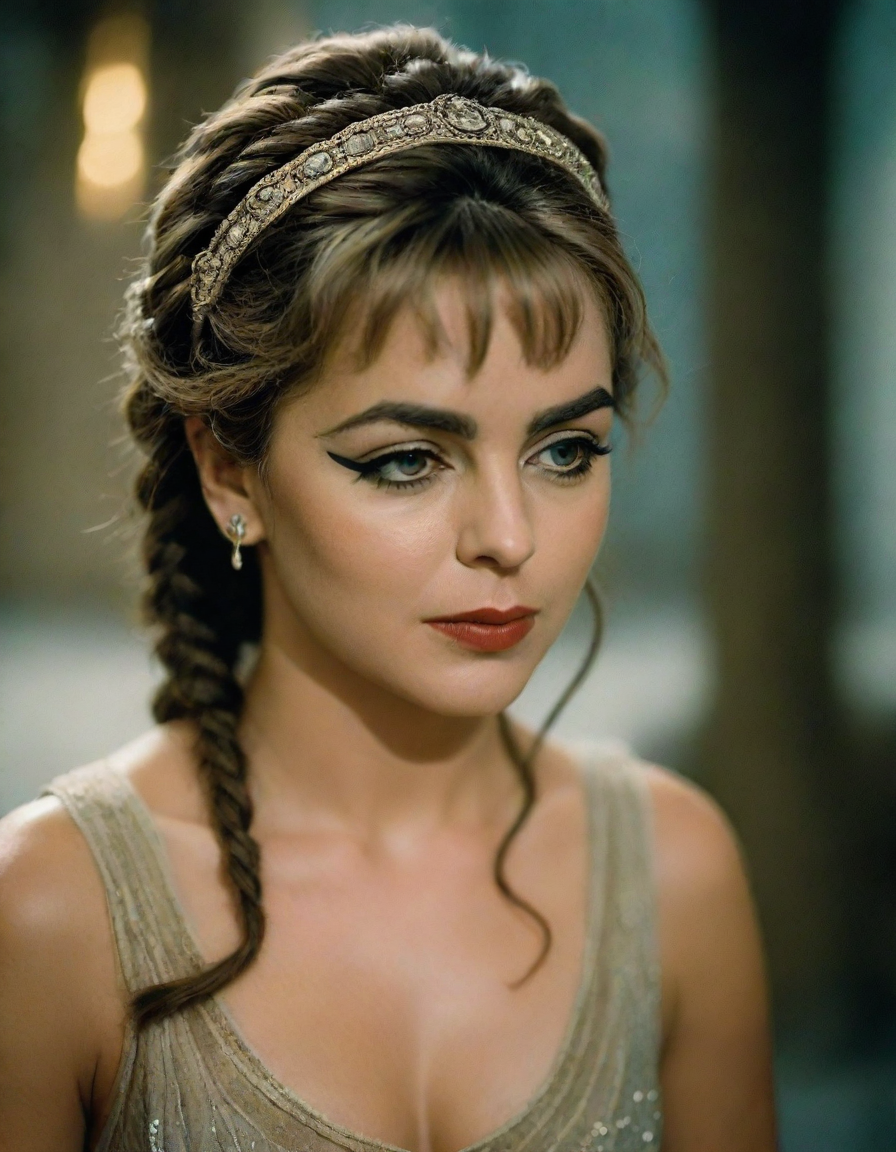

  0%|          | 0/6 [00:00<?, ?it/s]

Prompt:	a Woman dressed as Sappho by Auguste Mengin
Style:	Cinematic
Seed:	4402104630573960682



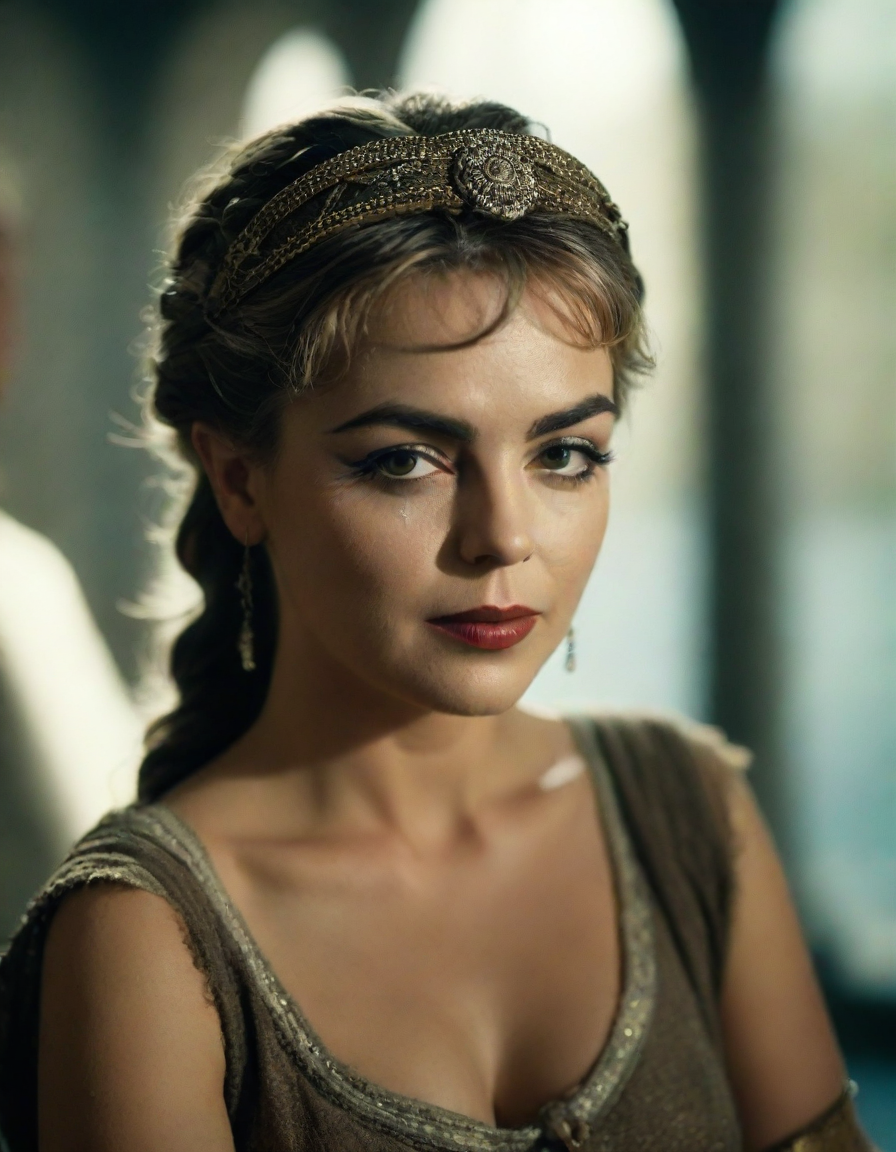

  0%|          | 0/6 [00:00<?, ?it/s]

Prompt:	a Woman dressed as Sappho by Auguste Mengin
Style:	Cinematic
Seed:	7445406523719063522



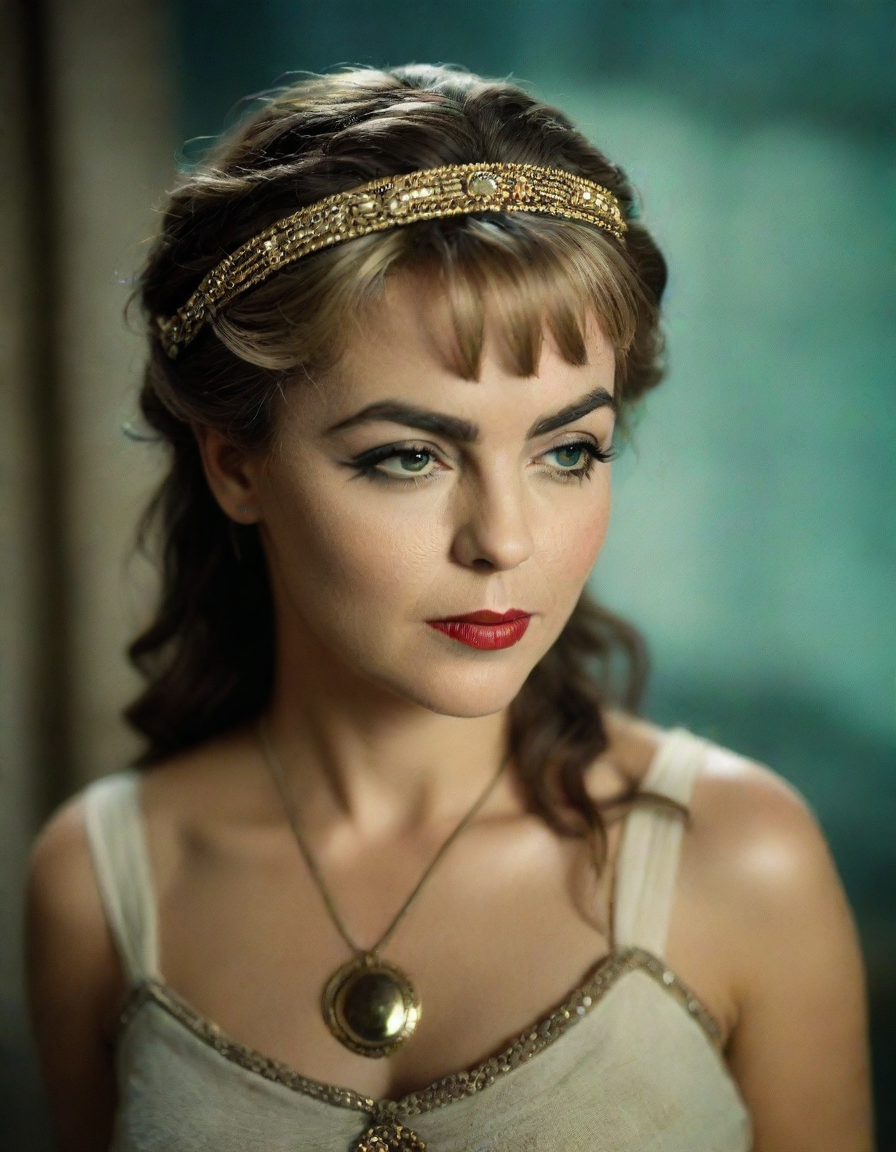

  0%|          | 0/6 [00:00<?, ?it/s]

Prompt:	a Woman dressed as Sappho by Auguste Mengin
Style:	Cinematic
Seed:	3118838610074276261



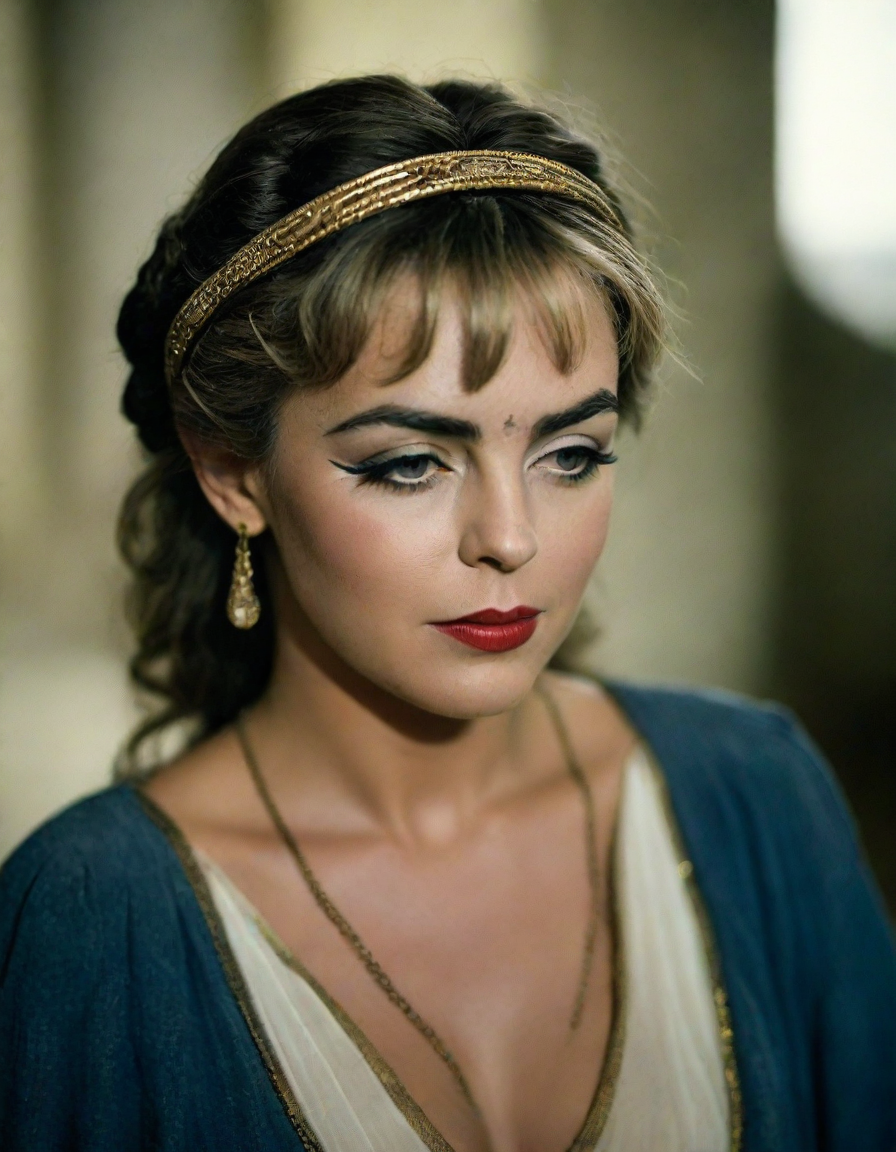

In [10]:
prompt = 'Nina Hagen as Sappho by Auguste Mengin'
prompt = 'A red haired woman standing in a lush green jungle'
prompt = 'A woman standing in a lush green jungle'
prompt = 'a Woman dressed as Sappho by Auguste Mengin'

image_count = 4
num_inference_steps=6
style = "Cinematic"
aspect = "7:9"


face_image = Image.open("/content/phs3.jpg")

# prepare face emb
face_info = app.get(cv2.cvtColor(np.array(face_image), cv2.COLOR_RGB2BGR))
face_info = sorted(face_info, key=lambda x:(x['bbox'][2]-x['bbox'][0])*x['bbox'][3]-x['bbox'][1])[-1] # only use the maximum face
face_emb = face_info['embedding']
face_kps = draw_kps(face_image, face_info['kps'])


orig_prompt = prompt
prompt = styles[style]["Positive"].replace("{prompt}", prompt)
negative_prompt = styles[style]["Negative"] + ", getty"

torch.cuda.empty_cache()


for i in  range(4):
  seed = random.randint(0, sys.maxsize)



  image = pipe(
    prompt, negative_prompt=negative_prompt,
    num_inference_steps=num_inference_steps,
    image_embeds=face_emb, image=face_kps, controlnet_conditioning_scale=0.8,
    guidance_scale=1.0,
    width=aspects[aspect]['x'], height=aspects[aspect]['y']
  ).images[0]

  print(f"Prompt:\t{orig_prompt}\nStyle:\t{style}\nSeed:\t{seed}")
  media.show_image(image)
